In [1]:
import torch
from mmdet.models.dense_heads.retina_head import RetinaHead
import numpy as np
import torch
from mmdet.datasets import replace_ImageToTensor
from mmcv.parallel import collate, scatter
from mmdet.datasets.pipelines import Compose
from mmdet.apis import (async_inference_detector, inference_detector,
                        init_detector, show_result_pyplot)

第一条从config文件加载RetinaHead并初始化，得到分类以及回归的输出，但是我怀疑这个是tmfile直接能给出的结果，具体去看一下最后一层的卷积的维度

In [2]:
self_head = RetinaHead(num_classes=80,
        in_channels=256,
        stacked_convs=4,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            octave_base_scale=4,
            scales_per_octave=3,
            ratios=[0.5, 1.0, 2.0],
            strides=[8, 16, 32, 64, 128]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[.0, .0, .0, .0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='FocalLoss',
            use_sigmoid=True,
            gamma=2.0,
            alpha=0.25,
            loss_weight=1.0),
        loss_bbox=dict(type='L1Loss', loss_weight=1.0))

x = torch.zeros(1, 256, 28, 28)
cls_score, bbox_pred = self_head.forward_single(x)
cls_per_anchor = cls_score.shape[1] / self_head.num_anchors
box_per_anchor = bbox_pred.shape[1] / self_head.num_anchors

/data/limingxuan/mmdetection/mmdet/models/dense_heads/anchor_head.py:117: UserWarning: DeprecationWarning: `num_anchors` is deprecated, for consistency or also use `num_base_priors` instead
  warnings.warn('DeprecationWarning: `num_anchors` is deprecated, '


这个地方初始化model是为了用demo.py里面的接口来获得img_metas

In [3]:
model = init_detector('./configs/retinanet/retinanet_r50_fpn_1x_coco.py', './checkpoints/retinanet_r50_fpn_1x_coco_20200130-c2398f9e.pth', device='cpu')

load checkpoint from local path: ./checkpoints/retinanet_r50_fpn_1x_coco_20200130-c2398f9e.pth
The model and loaded state dict do not match exactly

size mismatch for bbox_head.retina_cls.weight: copying a param with shape torch.Size([720, 256, 3, 3]) from checkpoint, the shape in current model is torch.Size([1200, 256, 3, 3]).
size mismatch for bbox_head.retina_cls.bias: copying a param with shape torch.Size([720]) from checkpoint, the shape in current model is torch.Size([1200]).
size mismatch for bbox_head.retina_reg.weight: copying a param with shape torch.Size([36, 256, 3, 3]) from checkpoint, the shape in current model is torch.Size([60, 256, 3, 3]).
size mismatch for bbox_head.retina_reg.bias: copying a param with shape torch.Size([36]) from checkpoint, the shape in current model is torch.Size([60]).


/data/limingxuan/mmdetection/mmdet/datasets/utils.py:69: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)


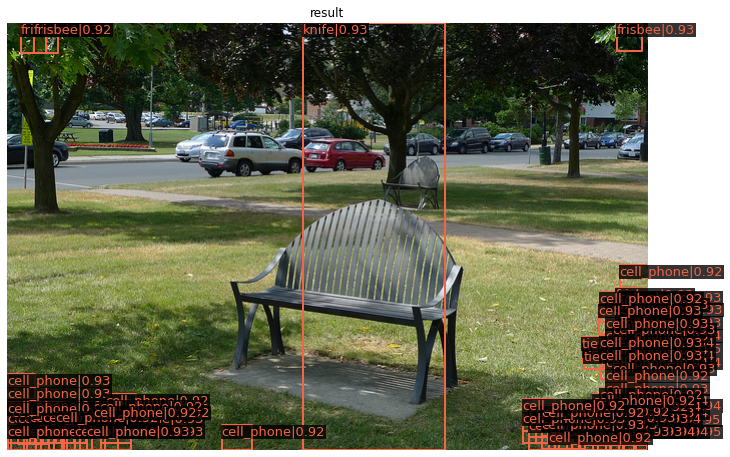

In [4]:
result = inference_detector(model, 'demo/demo.jpg')
show_result_pyplot(model, 'demo/demo.jpg', result)

In [26]:
    cfg = model.cfg
    imgs = 'demo/demo.jpg'
    if isinstance(imgs, (list, tuple)):
        is_batch = True
    else:
        imgs = [imgs]
        is_batch = False

    # cfg = model.cfg
    # device = next(model.parameters()).device  # model device

    if isinstance(imgs[0], np.ndarray):
        cfg = cfg.copy()
        # set loading pipeline type
        cfg.data.test.pipeline[0].type = 'LoadImageFromWebcam'

    cfg.data.test.pipeline = replace_ImageToTensor(cfg.data.test.pipeline)
    test_pipeline = Compose(cfg.data.test.pipeline)

    datas = []
    for img in imgs:
        # prepare data
        if isinstance(img, np.ndarray):
            # directly add img
            data = dict(img=img)
        else:
            # add information into dict
            data = dict(img_info=dict(filename=img), img_prefix=None)
        # build the data pipeline
        data = test_pipeline(data)
        datas.append(data)

    data = collate(datas, samples_per_gpu=len(imgs))
    # just get the actual data from DataContainer
    data['img_metas'] = [img_metas.data[0] for img_metas in data['img_metas']]
    data['img'] = [img.data[0] for img in data['img']]

/data/limingxuan/mmdetection/mmdet/datasets/utils.py:69: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)


这个地方的数据结构有一点点奇怪，包了好几层

In [9]:
img_meta_my = data['img_metas'][0]
img_meta_my

[{'filename': 'demo/demo.jpg',
  'ori_filename': 'demo/demo.jpg',
  'ori_shape': (427, 640, 3),
  'img_shape': (149, 224, 3),
  'pad_shape': (160, 224, 3),
  'scale_factor': array([0.35      , 0.34894612, 0.35      , 0.34894612], dtype=float32),
  'flip': False,
  'flip_direction': None,
  'img_norm_cfg': {'mean': array([123.675, 116.28 , 103.53 ], dtype=float32),
   'std': array([58.395, 57.12 , 57.375], dtype=float32),
   'to_rgb': True}}]

根据5个维度，以及上面获得的img_metas来获得anchor，anchor_list的第一个0是因为所有的tensor外面包着一个[]，第二个0是为了取最大尺度的特征图

In [19]:
anchor_list, valid_flag_list = self_head.get_anchors([(28, 28),(14,14),(7,7),(4,4),(2,2)], img_metas=img_meta_my, device='cpu')
anchor_max = anchor_list[0][0]

In [20]:
anchor_max = np.array(anchor_max)
anchor_max.shape

(7056, 4)

In [16]:
for i in anchor_max:
    print(i)

[-22.627417 -11.313708  22.627417  11.313708]
[-28.508759 -14.254379  28.508759  14.254379]
[-35.918785 -17.959393  35.918785  17.959393]
[-16. -16.  16.  16.]
[-20.158737 -20.158737  20.158737  20.158737]
[-25.398417 -25.398417  25.398417  25.398417]
[-11.313708 -22.627417  11.313708  22.627417]
[-14.254379 -28.508759  14.254379  28.508759]
[-17.959393 -35.918785  17.959393  35.918785]
[-14.627417 -11.313708  30.627417  11.313708]
[-20.508759 -14.254379  36.50876   14.254379]
[-27.918785 -17.959393  43.918785  17.959393]
[ -8. -16.  24.  16.]
[-12.158737 -20.158737  28.158737  20.158737]
[-17.398417 -25.398417  33.398415  25.398417]
[ -3.3137083 -22.627417   19.31371    22.627417 ]
[ -6.2543793 -28.508759   22.25438    28.508759 ]
[ -9.959393 -35.918785  25.959393  35.918785]
[ -6.6274166 -11.313708   38.62742    11.313708 ]
[-12.508759 -14.254379  44.50876   14.254379]
[-19.918785 -17.959393  51.918785  17.959393]
[  0. -16.  32.  16.]
[ -4.158737 -20.158737  36.158737  20.158737]
[ 

In [21]:
bbox_pred = bbox_pred.permute(0, 2, 3, 1).reshape(-1, 4)
# anchors = anchors.reshape(-1, 4)

In [22]:
bbox_pred.size()

torch.Size([7056, 4])

In [23]:
bbox = self_head.bbox_coder.decode(anchor_max, bbox_pred)

In [24]:
bbox

tensor([[-21.8321, -11.3167,  23.6969,  10.8734],
        [-27.9969, -13.7882,  28.8183,  14.6930],
        [-37.1397, -17.4779,  35.6735,  17.8663],
        ...,
        [204.3537, 193.8689, 227.2769, 238.4093],
        [201.7861, 187.4559, 230.6906, 244.0675],
        [197.9598, 178.7858, 234.4747, 251.8943]],
       grad_fn=<ReshapeAliasBackward0>)

In [21]:
import cv2

In [22]:
img = cv2.imread("SGJX04722.jpg")

In [23]:
img = cv2.resize(img, (640,640))

In [24]:
cv2.imwrite("im.jpg",img)

True